In [82]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from urllib import urlretrieve
import cPickle as pickle
import os
import gzip
import numpy as np
import theano
import lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import visualize
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import os
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import cPickle as pickle

In [83]:
TrainingSet = '.\\data\\fer2013.csv'
#loading the data and splitting into training and test set
df = read_csv(os.path.expanduser(TrainingSet))
df['pixels'] = df['pixels'].apply(lambda im: np.fromstring(im, sep=' '))
output_label = np.array(df['emotion'].values)
features_image = np.vstack(df['pixels'].values)  # scale pixel values to [0, 1]
features_image = features_image.astype(np.float32)
x_train = features_image[:30000]
y_train = output_label[:30000]
x_test = features_image[30000:]
y_test = output_label[30000:]
x_train = x_train.reshape((-1, 1, 48, 48))
x_test = x_test.reshape((-1, 1, 48, 48))
x_flipped = x_train[:, :, :, ::-1]
x_train = np.concatenate((x_train, x_flipped), axis = 0)
y_train = np.concatenate((y_train, y_train), axis = 0)
y_train = y_train.astype(np.uint8)
y_test = y_test.astype(np.uint8)

In [84]:
net_fin= NeuralNet(
    layers=[('input', layers.InputLayer),
            ('conv2d1', layers.Conv2DLayer),
            ('maxpool1', layers.MaxPool2DLayer),
            ('dropout1', layers.DropoutLayer),
            ('conv2d2', layers.Conv2DLayer),
            ('maxpool2', layers.MaxPool2DLayer),
            ('dropout2', layers.DropoutLayer),
            ('conv2d3', layers.Conv2DLayer),
            ('maxpool3', layers.MaxPool2DLayer),
            ('dropout3', layers.DropoutLayer),
            ('conv2d4', layers.Conv2DLayer),
            ('maxpool4', layers.MaxPool2DLayer),
            ('dropout4', layers.DropoutLayer),
            ('dense1', layers.DenseLayer),
            ('dropout5', layers.DropoutLayer),
            ('dense2', layers.DenseLayer),
            ('dropout6', layers.DropoutLayer),
            ('output', layers.DenseLayer),
            ],
    # input layer
    input_shape=(None, 1, 48, 48),
    
    # layer conv2d1
    conv2d1_num_filters=64,
    conv2d1_filter_size=(3, 3),
    conv2d1_nonlinearity=lasagne.nonlinearities.rectify,
    conv2d1_W= np.concatenate(prev_mod['conv1'][0], axis=0).reshape((64, 1, 3, 3)),     
    maxpool1_pool_size=(2, 2),    
    dropout1_p=0.2,
    
    # layer conv2d2    
    conv2d2_num_filters=128,
    conv2d2_filter_size=(3, 3),
    conv2d2_nonlinearity=lasagne.nonlinearities.rectify, 
    conv2d2_W= np.concatenate(prev_mod['conv2'][0], axis=0).reshape((128,64,3,3)),
    maxpool2_pool_size=(2, 2),
    dropout2_p=0.2,
    
     # layer conv2d3 
    conv2d3_num_filters=512,
    conv2d3_filter_size=(3, 3),
    conv2d3_nonlinearity=lasagne.nonlinearities.rectify,
    conv2d3_W=np.concatenate(prev_mod['conv3'][0], axis=0).reshape((512,128,3,3)),
    maxpool3_pool_size=(2, 2),
    dropout3_p=0.2,
    
    ## layer conv2d4
    conv2d4_num_filters=512,
    conv2d4_filter_size=(3, 3),
    conv2d4_nonlinearity=lasagne.nonlinearities.rectify,  
    conv2d4_W=np.concatenate(prev_mod['conv4'][0], axis=0).reshape((512,512,3,3)), 
    maxpool4_pool_size=(2, 2),
    dropout4_p=0.2,    
    
    # dense fully connected layer 1
    dense1_num_units=256,
    dense1_nonlinearity=lasagne.nonlinearities.rectify,  
    dense1_W=np.concatenate(prev_mod['hidden4'][0], axis=0).reshape(512,256),   
    dropout5_p=0.2,    
    
    # dense fully connected layer 2
    dense2_num_units=512,
    dense2_nonlinearity=lasagne.nonlinearities.rectify, 
    dense2_W=np.concatenate(prev_mod['hidden5'][0], axis=0).reshape(256,512),     
    dropout6_p=0.2,    
    
    # output Layer
    output_nonlinearity=lasagne.nonlinearities.softmax,
    output_num_units=7,
    
    # optimization method params
    update=nesterov_momentum,
    #update_learning_rate=theano.shared(float32(0.05)),
    #update_momentum=theano.shared(float32(0.9)),  
    update_learning_rate = 0.005,
    update_momentum = 0.9,   
    max_epochs=100,
    verbose=1,
    )
# Train the network
deepFacialRecognition = net_fin.fit(x_train, y_train)

# Neural Network with 3291143 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x48x48
  1  conv2d1   64x46x46
  2  maxpool1  64x23x23
  3  dropout1  64x23x23
  4  conv2d2   128x21x21
  5  maxpool2  128x10x10
  6  dropout2  128x10x10
  7  conv2d3   512x8x8
  8  maxpool3  512x4x4
  9  dropout3  512x4x4
 10  conv2d4   512x2x2
 11  maxpool4  512x1x1
 12  dropout4  512x1x1
 13  dense1    256
 14  dropout5  256
 15  dense2    512
 16  dropout6  512
 17  output    7



In [85]:
f = gzip.open('.\\TrainedModels\\net_final_output.pickle.gz', 'rb')
pvals = pickle.load(f)
f.close()
[p.set_value(pval) for (p, pval) in zip(lasagne.layers.get_all_params(net_fin._output_layer), pvals)]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [86]:
y_pred = net_fin.predict(x_test)

In [91]:
from __future__ import division
y_diff = y_pred - y_test
print 'Accuracy of the model: ' + str((len(y_diff) - len(y_diff[y_diff != 0]))/ len(y_diff))

Accuracy of the model: 0.595549515882


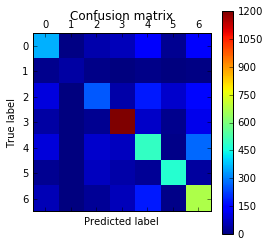

In [24]:
cm = confusion_matrix(y_test, y_pred)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [25]:
cm

array([[ 361,    5,   50,   65,  133,   21,  145],
       [  17,   40,   11,    3,   12,    1,    6],
       [  99,    3,  257,   47,  183,   83,  156],
       [  39,    0,   19, 1204,   76,   17,  113],
       [  98,    0,   83,   66,  494,   13,  274],
       [  20,    2,   66,   46,   26,  476,   37],
       [  58,    2,   24,   65,  183,   14,  674]])

In [ ]:
%matplotlib inline
#index = 1323
for index in range(10,25):
    plt.imshow(x_test[index][0], cmap = 'gray')
    plt.show()
    emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    print 'Predicted Emotion: ' + str(emotions[y_pred[index]])
    print 'Actual Emotion:    ' + str(emotions[y_test[index]])

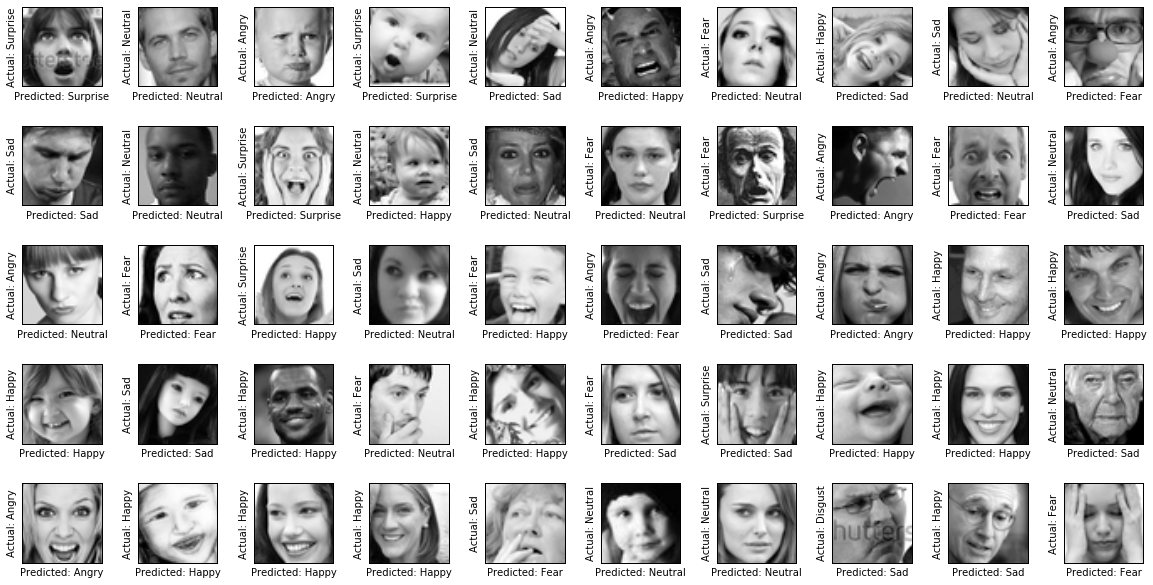

In [93]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
def plot_sample(x, axis):
    #img = x.reshape(48, 48)
    axis.imshow(x, cmap='gray')      

fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.05)
count = 7
start_range = 50 * (count - 1)
end_range = 50 * count
for i in range(start_range, end_range):   
    ax = fig.add_subplot(10, 10, i - (50*(count - 1)) + 1, xticks=[], yticks=[])
    ax.set_xlabel('Predicted: ' + str(emotions[y_pred[i]]) )
    ax.set_ylabel('Actual: ' + str(emotions[y_test[i]]))
    plot_sample(x_test[i][0], ax)

plt.show()